Step 1: Import Data

In [5]:
# =========================
# Cell 1: Setup & discovery
# =========================
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Reproducibility (for TF/Keras later too)
import random
random.seed(44)
np.random.seed(44)

# ---- Configure your base path (edit if needed) ----
BASE_PATH = r"C:\Self Learning\Research Papers\UOW Research Papers\eSport Players with EEG Data\eeg-data-loso-cv"

print(f"[INFO] Base path set to:\n{BASE_PATH}")

# Discover subject folders (directories only)
all_folders = [p for p in sorted(os.listdir(BASE_PATH)) if os.path.isdir(os.path.join(BASE_PATH, p))]
print(f"[INFO] Found {len(all_folders)} folders:", all_folders)

# Sanity check the expected count
assert len(all_folders) == 18, f"Expected 18 folders, found {len(all_folders)}."

# LosoCV selection
TEST_SUBJECT = "Jack"
print(f"[INFO] Selected test subject (leave-one-subject-out): {TEST_SUBJECT}")

train_subjects = [s for s in all_folders if s.lower() != TEST_SUBJECT.lower()]
print(f"[INFO] Training subjects ({len(train_subjects)}): {train_subjects}")


[INFO] Base path set to:
C:\Self Learning\Research Papers\UOW Research Papers\eSport Players with EEG Data\eeg-data-loso-cv
[INFO] Found 18 folders: ['Amin', 'Amin1', 'Cole', 'Daniel', 'Ismayil', 'Jack', 'James', 'Josh', 'Marjan', 'Max', 'Mina', 'Mina 1', 'Mina 3', 'Mohammad', 'Mona', 'Roddy', 'Sam', 'adam']
[INFO] Selected test subject (leave-one-subject-out): Jack
[INFO] Training subjects (17): ['Amin', 'Amin1', 'Cole', 'Daniel', 'Ismayil', 'James', 'Josh', 'Marjan', 'Max', 'Mina', 'Mina 1', 'Mina 3', 'Mohammad', 'Mona', 'Roddy', 'Sam', 'adam']


Step 2: Train Test Split

In [6]:
# ==========================================================
# Cell 2: Load data per subject, split into train/test (LOSO)
# ==========================================================
def load_subject(subject_folder: str):
    """
    Loads EEG data (*.npy ending with 'pp.npy') and labels (*.npy ending with 'label.npy')
    from a subject folder. Returns (X, y).
    Expected shapes per subject (typical): X -> (265, 14, 200), y -> (265,)
    """
    subj_path = os.path.join(BASE_PATH, subject_folder)
    # Find files by suffix
    eeg_files = glob.glob(os.path.join(subj_path, "*pp.npy"))
    label_files = glob.glob(os.path.join(subj_path, "*label*.npy"))

    if len(eeg_files) != 1 or len(label_files) != 1:
        raise FileNotFoundError(f"Could not uniquely find pp.npy & label.npy in: {subj_path}\n"
                                f"eeg_files={eeg_files}\nlabel_files={label_files}")

    X = np.load(eeg_files[0])
    y = np.load(label_files[0])

    # Ensure expected ranks: (N, 14, 200) and (N,)
    X = np.asarray(X).squeeze()
    y = np.asarray(y).squeeze()

    if X.ndim != 3:
        raise ValueError(f"EEG array rank must be 3 (N,14,200). Got shape {X.shape} for {subject_folder}.")
    if y.ndim != 1:
        raise ValueError(f"Label array rank must be 1 (N,). Got shape {y.shape} for {subject_folder}.")

    print(f"[LOAD] {subject_folder}: X{X.shape}, y{y.shape}")
    return X, y

# Collect training data (all except test) and test data (adam)
X_train_list, y_train_list = [], []
X_test, y_test = None, None

print("[INFO] Loading data...")
for subj in all_folders:
    X_subj, y_subj = load_subject(subj)

    if subj.lower() == TEST_SUBJECT.lower():
        print(f"[SPLIT] Assigning '{subj}' to TEST set")
        X_test, y_test = X_subj, y_subj
    else:
        print(f"[SPLIT] Assigning '{subj}' to TRAIN set")
        X_train_list.append(X_subj)
        y_train_list.append(y_subj)

# Concatenate training subjects along samples axis
X_train = np.concatenate(X_train_list, axis=0) if len(X_train_list) else None
y_train = np.concatenate(y_train_list, axis=0) if len(y_train_list) else None

print("\n[SUMMARY] Split overview")
print(f" - Test folder: {TEST_SUBJECT}")
print(f" - Train folders ({len(train_subjects)}): {train_subjects}")
print(f" - X_train shape: {None if X_train is None else X_train.shape}")
print(f" - y_train shape: {None if y_train is None else y_train.shape}")
print(f" - X_test  shape: {None if X_test  is None else X_test.shape}")
print(f" - y_test  shape: {None if y_test  is None else y_test.shape}")

# Optional: assert the expected shape if each train subject has 265 samples
expected_train_N = 265 * len(train_subjects)  # 265 * 17 = 4505
if X_train is not None:
    assert X_train.shape[0] == expected_train_N, (
        f"Expected {expected_train_N} train samples, found {X_train.shape[0]}."
    )
    assert X_train.shape[1:] == (14, 200), f"Expected train feature shape (14,200), got {X_train.shape[1:]}."
    assert y_train.shape == (expected_train_N,), f"Expected y_train shape ({expected_train_N},), got {y_train.shape}."

print("[INFO] Train/Test split complete.")


[INFO] Loading data...
[LOAD] Amin: X(265, 14, 200), y(265,)
[SPLIT] Assigning 'Amin' to TRAIN set
[LOAD] Amin1: X(265, 14, 200), y(265,)
[SPLIT] Assigning 'Amin1' to TRAIN set
[LOAD] Cole: X(265, 14, 200), y(265,)
[SPLIT] Assigning 'Cole' to TRAIN set
[LOAD] Daniel: X(265, 14, 200), y(265,)
[SPLIT] Assigning 'Daniel' to TRAIN set
[LOAD] Ismayil: X(265, 14, 200), y(265,)
[SPLIT] Assigning 'Ismayil' to TRAIN set
[LOAD] Jack: X(265, 14, 200), y(265,)
[SPLIT] Assigning 'Jack' to TEST set
[LOAD] James: X(265, 14, 200), y(265,)
[SPLIT] Assigning 'James' to TRAIN set
[LOAD] Josh: X(265, 14, 200), y(265,)
[SPLIT] Assigning 'Josh' to TRAIN set
[LOAD] Marjan: X(265, 14, 200), y(265,)
[SPLIT] Assigning 'Marjan' to TRAIN set
[LOAD] Max: X(265, 14, 200), y(265,)
[SPLIT] Assigning 'Max' to TRAIN set
[LOAD] Mina: X(265, 14, 200), y(265,)
[SPLIT] Assigning 'Mina' to TRAIN set
[LOAD] Mina 1: X(265, 14, 200), y(265,)
[SPLIT] Assigning 'Mina 1' to TRAIN set
[LOAD] Mina 3: X(265, 14, 200), y(265,)
[SPLIT

In [7]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

Step 3: Data Normalisation

In [8]:
# =========================================================
# Cell 3: Normalization (using TRAIN mean/std for both sets)
# =========================================================
print("[INFO] Starting normalization...")

# Following your template but adapted to (N, 14, 200) -> add a channel dim to be (N, 14, 200, 1)
train_data = np.expand_dims(X_train, axis=-1)  # (N,14,200,1)
test_data  = np.expand_dims(X_test,  axis=-1)  # (M,14,200,1)

print(f"[SHAPE] train_data: {train_data.shape}  test_data: {test_data.shape}")

# ---- Step 1: Compute mean & std from the training set only ----
# Axis per your template: (0, 2, 3) = average over samples, time, channel -> keep electrode dimension
train_mean = np.mean(train_data, axis=(0, 2, 3), keepdims=True)  # Shape: (1, 14, 1, 1)
train_std  = np.std(  train_data, axis=(0, 2, 3), keepdims=True)  # Shape: (1, 14, 1, 1)

# Avoid divide-by-zero
eps = 1e-7
train_std = np.where(train_std < eps, eps, train_std)

print(f"[STATS] train_mean shape: {train_mean.shape}, train_std shape: {train_std.shape}")

# ---- Step 2: Apply normalization using training mean & std ----
train_data_norm = (train_data - train_mean) / train_std
test_data_norm  = (test_data  - train_mean) / train_std  # IMPORTANT: use TRAIN stats for TEST too

print("[INFO] Normalization complete.")
print(f"[SHAPE] train_data_norm: {train_data_norm.shape}, test_data_norm: {test_data_norm.shape}")



[INFO] Starting normalization...
[SHAPE] train_data: (4505, 14, 200, 1)  test_data: (265, 14, 200, 1)
[STATS] train_mean shape: (1, 14, 1, 1), train_std shape: (1, 14, 1, 1)
[INFO] Normalization complete.
[SHAPE] train_data_norm: (4505, 14, 200, 1), test_data_norm: (265, 14, 200, 1)


Step 4: Modeling

[TRAIN] Using TRAIN set for CV -> Xtr: (4505, 14, 200, 1), ytr: (4505,)
[INFO] daniel (TEST) will be used only after CV for final evaluation (Steps 5–6).
[CV] Starting 5-fold cross-validation...

[CV] Fold 1/5
[CV] Fold 1 shapes -> Train: (3604, 14, 200, 1), Val: (901, 14, 200, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)                            │ (None, 14, 200, 1)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d (Conv2D)                                     │ (None, 14, 200, 16)                    │                 1,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization (BatchNormalization)            │ (None, 14, 200, 16)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ depthwise_conv2d (DepthwiseConv2D)                  │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_1 (BatchNormalization)          │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ activation (Activation)                             │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ average_pooling2d (AveragePooling2D)                │ (None, 1, 50, 32)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout (Dropout)                                   │ (None, 1, 50, 32)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ separable_conv2d (SeparableConv2D)                  │ (None, 1, 50, 16)                      │                 1,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_2 (BatchNormalization)          │ (None, 1, 50, 16)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ activation_1 (Activation)                           │ (None, 1, 50, 16)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ average_pooling2d_1 (AveragePooling2D)              │ (None, 1, 6, 16)                       │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout_1 (Dropout)                                 │ (None, 1, 6, 16)                       │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ flatten (Flatten)                                   │ (None, 96)                             │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense (Dense)                                       │ (None, 64)                             │                 6,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_1 (Dense)                                     │ (None, 1)                              │                   
└─────────────────────────────────────────────────────┴─

 Total params: 9,025 (35.25 KB)

 Trainable params: 8,897 (34.75 KB)

 Non-trainable params: 128 (512.00 B)

None
[CALLBACKS] Setting up EarlyStopping & ReduceLROnPlateau...
[CV] Training fold 1...
Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.6656 - loss: 0.6185 - val_accuracy: 0.6981 - val_loss: 0.6661 - learning_rate: 0.0010
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8413 - loss: 0.4245 - val_accuracy: 0.5716 - val_loss: 0.6046 - learning_rate: 0.0010
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9093 - loss: 0.2633 - val_accuracy: 0.6626 - val_loss: 0.4915 - learning_rate: 0.0010
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9423 - loss: 0.1656 - val_accuracy: 0.9367 - val_loss: 0.2080 - learning_rate: 0.0010
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9625 - loss: 0.1131 - val_accuracy: 0.9567 - val_loss: 0.1116 - learning_rate: 0.0010
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9684 - loss: 0.0981 - val_accuracy: 0.9667 - val_loss: 0.1043 - learning_rate: 0.0010

[CV] Fold 1 training complete.
[SAVE] Saved fold-1 model -> jack-fold1.h5
[CV][Fold 1] last-epoch -> train_acc: 0.9972, val_acc: 0.9933, train_loss: 0.0112, val_loss: 0.0165
[CV][Fold 1] best -> epoch: 24, best_val_loss: 0.0126, best_val_acc: 0.9967
[CM][Fold 1] Confusion Matrix (rows=true [0,1], cols=pred [0,1]):
[[483   1]
 [  2 415]]
[CM][Fold 1] TN=483, FP=1, FN=2, TP=415
[CM][Fold 1] accuracy=0.9967, precision=0.9976, recall=0.9952, f1=0.9964


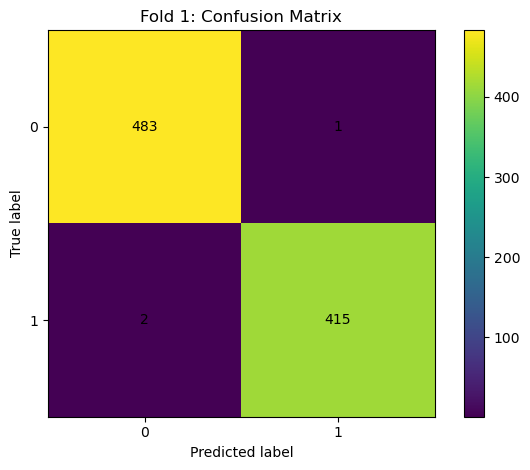

[PLOT] Fold 1: Accuracy / Loss curves


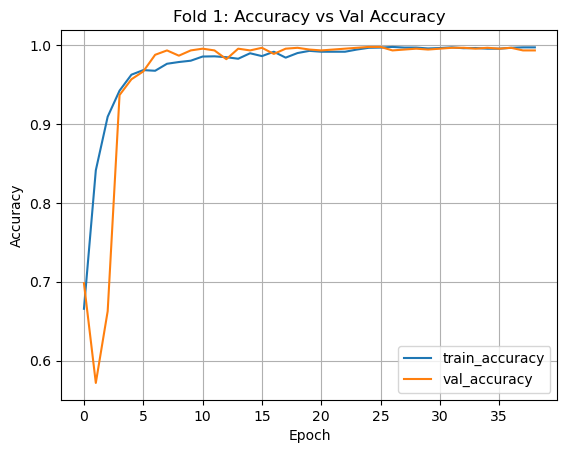

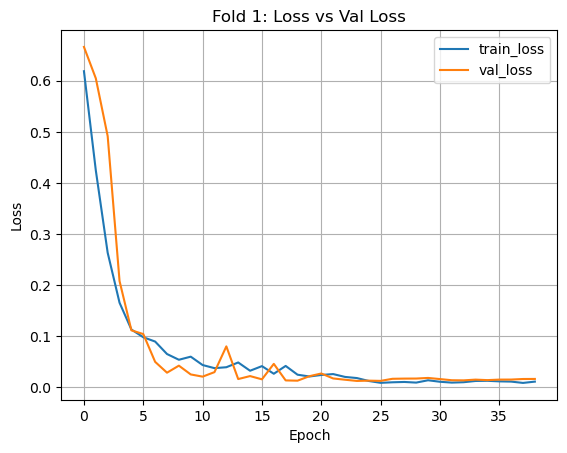


[CV] Fold 2/5
[CV] Fold 2 shapes -> Train: (3604, 14, 200, 1), Val: (901, 14, 200, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer_1 (InputLayer)                          │ (None, 14, 200, 1)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_1 (Conv2D)                                   │ (None, 14, 200, 16)                    │                 1,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_3 (BatchNormalization)          │ (None, 14, 200, 16)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ depthwise_conv2d_1 (DepthwiseConv2D)                │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_4 (BatchNormalization)          │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ activation_2 (Activation)                           │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ average_pooling2d_2 (AveragePooling2D)              │ (None, 1, 50, 32)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout_2 (Dropout)                                 │ (None, 1, 50, 32)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ separable_conv2d_1 (SeparableConv2D)                │ (None, 1, 50, 16)                      │                 1,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_5 (BatchNormalization)          │ (None, 1, 50, 16)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ activation_3 (Activation)                           │ (None, 1, 50, 16)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ average_pooling2d_3 (AveragePooling2D)              │ (None, 1, 6, 16)                       │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout_3 (Dropout)                                 │ (None, 1, 6, 16)                       │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ flatten_1 (Flatten)                                 │ (None, 96)                             │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_2 (Dense)                                     │ (None, 64)                             │                 6,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_3 (Dense)                                     │ (None, 1)                              │                   
└─────────────────────────────────────────────────────┴─

 Total params: 9,025 (35.25 KB)

 Trainable params: 8,897 (34.75 KB)

 Non-trainable params: 128 (512.00 B)

None
[CALLBACKS] Setting up EarlyStopping & ReduceLROnPlateau...
[CV] Training fold 2...
Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.6459 - loss: 0.6323 - val_accuracy: 0.5205 - val_loss: 0.6741 - learning_rate: 0.0010
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8321 - loss: 0.4245 - val_accuracy: 0.6226 - val_loss: 0.6059 - learning_rate: 0.0010
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9156 - loss: 0.2404 - val_accuracy: 0.7270 - val_loss: 0.4578 - learning_rate: 0.0010
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9437 - loss: 0.1594 - val_accuracy: 0.9168 - val_loss: 0.2271 - learning_rate: 0.0010
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9509 - loss: 0.1311 - val_accuracy: 0.9600 - val_loss: 0.1168 - learning_rate: 0.0010
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9639 - loss: 0.0969 - val_accuracy: 0.9778 - val_loss: 0.0715 - learning_rate: 0.0010

[CV] Fold 2 training complete.
[SAVE] Saved fold-2 model -> jack-fold2.h5
[CV][Fold 2] last-epoch -> train_acc: 0.9936, val_acc: 0.9967, train_loss: 0.0191, val_loss: 0.0112
[CV][Fold 2] best -> epoch: 29, best_val_loss: 0.0083, best_val_acc: 0.9967
[CM][Fold 2] Confusion Matrix (rows=true [0,1], cols=pred [0,1]):
[[470   1]
 [  2 428]]
[CM][Fold 2] TN=470, FP=1, FN=2, TP=428
[CM][Fold 2] accuracy=0.9967, precision=0.9977, recall=0.9953, f1=0.9965


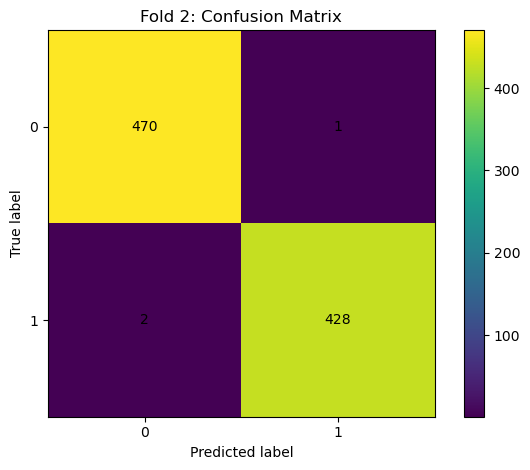

[PLOT] Fold 2: Accuracy / Loss curves


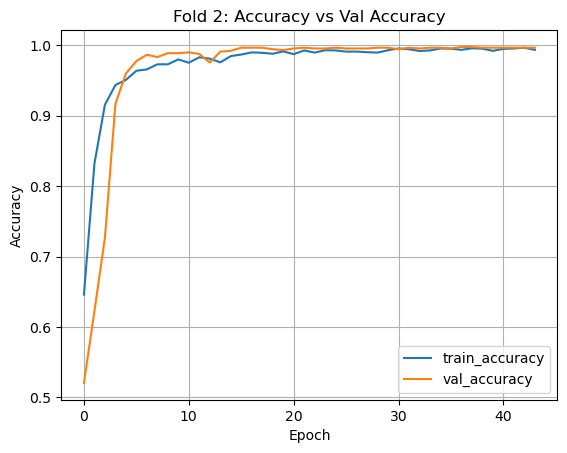

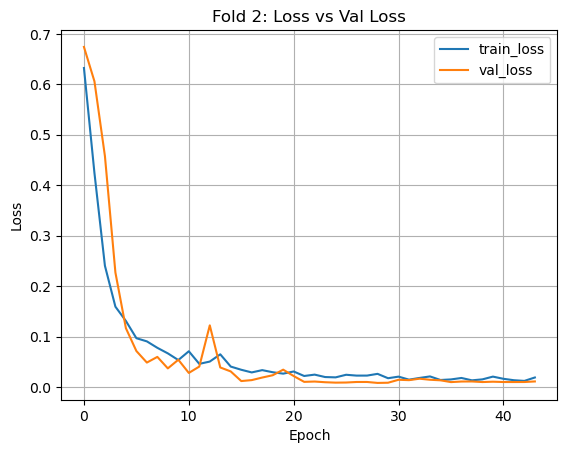


[CV] Fold 3/5
[CV] Fold 3 shapes -> Train: (3604, 14, 200, 1), Val: (901, 14, 200, 1)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer_2 (InputLayer)                          │ (None, 14, 200, 1)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_2 (Conv2D)                                   │ (None, 14, 200, 16)                    │                 1,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_6 (BatchNormalization)          │ (None, 14, 200, 16)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ depthwise_conv2d_2 (DepthwiseConv2D)                │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_7 (BatchNormalization)          │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ activation_4 (Activation)                           │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ average_pooling2d_4 (AveragePooling2D)              │ (None, 1, 50, 32)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout_4 (Dropout)                                 │ (None, 1, 50, 32)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ separable_conv2d_2 (SeparableConv2D)                │ (None, 1, 50, 16)                      │                 1,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_8 (BatchNormalization)          │ (None, 1, 50, 16)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ activation_5 (Activation)                           │ (None, 1, 50, 16)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ average_pooling2d_5 (AveragePooling2D)              │ (None, 1, 6, 16)                       │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout_5 (Dropout)                                 │ (None, 1, 6, 16)                       │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ flatten_2 (Flatten)                                 │ (None, 96)                             │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_4 (Dense)                                     │ (None, 64)                             │                 6,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_5 (Dense)                                     │ (None, 1)                              │                   
└─────────────────────────────────────────────────────┴─

 Total params: 9,025 (35.25 KB)

 Trainable params: 8,897 (34.75 KB)

 Non-trainable params: 128 (512.00 B)

None
[CALLBACKS] Setting up EarlyStopping & ReduceLROnPlateau...
[CV] Training fold 3...
Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.6376 - loss: 0.6462 - val_accuracy: 0.6127 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7741 - loss: 0.5050 - val_accuracy: 0.6260 - val_loss: 0.6405 - learning_rate: 0.0010
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8721 - loss: 0.3333 - val_accuracy: 0.6937 - val_loss: 0.5285 - learning_rate: 0.0010
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9159 - loss: 0.2402 - val_accuracy: 0.8280 - val_loss: 0.3394 - learning_rate: 0.0010
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9426 - loss: 0.1706 - val_accuracy: 0.9634 - val_loss: 0.1256 - learning_rate: 0.0010
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9578 - loss: 0.1264 - val_accuracy: 0.9900 - val_loss: 0.0483 - learning_rate: 0.0010

[CV] Fold 3 training complete.
[SAVE] Saved fold-3 model -> jack-fold3.h5
[CV][Fold 3] last-epoch -> train_acc: 0.9978, val_acc: 1.0000, train_loss: 0.0072, val_loss: 0.0004
[CV][Fold 3] best -> epoch: 60, best_val_loss: 0.0004, best_val_acc: 1.0000
[CM][Fold 3] Confusion Matrix (rows=true [0,1], cols=pred [0,1]):
[[461   0]
 [  0 440]]
[CM][Fold 3] TN=461, FP=0, FN=0, TP=440
[CM][Fold 3] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000


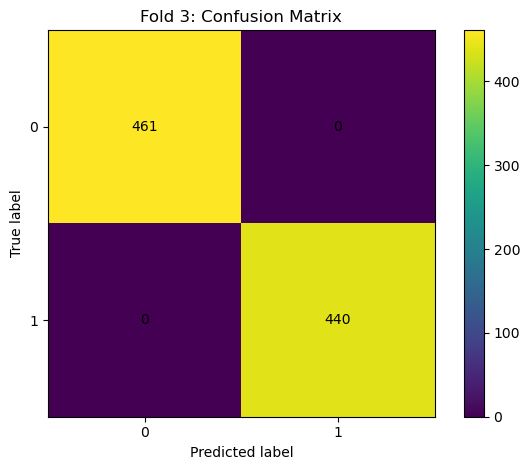

[PLOT] Fold 3: Accuracy / Loss curves


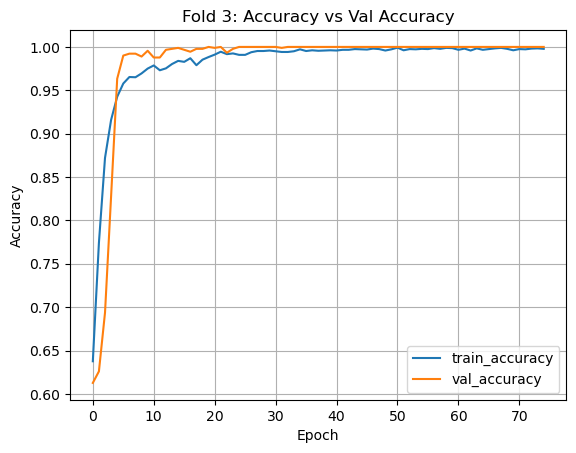

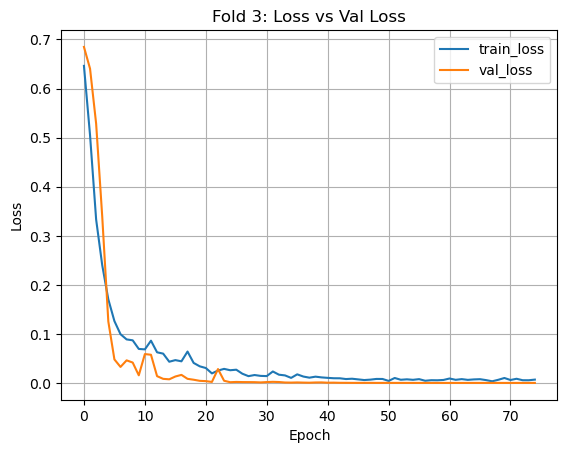


[CV] Fold 4/5
[CV] Fold 4 shapes -> Train: (3604, 14, 200, 1), Val: (901, 14, 200, 1)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer_3 (InputLayer)                          │ (None, 14, 200, 1)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_3 (Conv2D)                                   │ (None, 14, 200, 16)                    │                 1,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_9 (BatchNormalization)          │ (None, 14, 200, 16)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ depthwise_conv2d_3 (DepthwiseConv2D)                │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_10 (BatchNormalization)         │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ activation_6 (Activation)                           │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ average_pooling2d_6 (AveragePooling2D)              │ (None, 1, 50, 32)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout_6 (Dropout)                                 │ (None, 1, 50, 32)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ separable_conv2d_3 (SeparableConv2D)                │ (None, 1, 50, 16)                      │                 1,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_11 (BatchNormalization)         │ (None, 1, 50, 16)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ activation_7 (Activation)                           │ (None, 1, 50, 16)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ average_pooling2d_7 (AveragePooling2D)              │ (None, 1, 6, 16)                       │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout_7 (Dropout)                                 │ (None, 1, 6, 16)                       │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ flatten_3 (Flatten)                                 │ (None, 96)                             │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_6 (Dense)                                     │ (None, 64)                             │                 6,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_7 (Dense)                                     │ (None, 1)                              │                   
└─────────────────────────────────────────────────────┴─

 Total params: 9,025 (35.25 KB)

 Trainable params: 8,897 (34.75 KB)

 Non-trainable params: 128 (512.00 B)

None
[CALLBACKS] Setting up EarlyStopping & ReduceLROnPlateau...
[CV] Training fold 4...
Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6185 - loss: 0.6703 - val_accuracy: 0.4994 - val_loss: 0.6883 - learning_rate: 0.0010
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7991 - loss: 0.4636 - val_accuracy: 0.6226 - val_loss: 0.6293 - learning_rate: 0.0010
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9023 - loss: 0.2666 - val_accuracy: 0.7181 - val_loss: 0.4777 - learning_rate: 0.0010
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9342 - loss: 0.1810 - val_accuracy: 0.8935 - val_loss: 0.3143 - learning_rate: 0.0010
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9492 - loss: 0.1530 - val_accuracy: 0.9445 - val_loss: 0.1454 - learning_rate: 0.0010
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9592 - loss: 0.1166 - val_accuracy: 0.9656 - val_loss: 0.0784 - learning_rate: 0.0010

[CV] Fold 4 training complete.
[SAVE] Saved fold-4 model -> jack-fold4.h5
[CV][Fold 4] last-epoch -> train_acc: 0.9933, val_acc: 0.9978, train_loss: 0.0196, val_loss: 0.0141
[CV][Fold 4] best -> epoch: 29, best_val_loss: 0.0094, best_val_acc: 0.9967
[CM][Fold 4] Confusion Matrix (rows=true [0,1], cols=pred [0,1]):
[[468   2]
 [  1 430]]
[CM][Fold 4] TN=468, FP=2, FN=1, TP=430
[CM][Fold 4] accuracy=0.9967, precision=0.9954, recall=0.9977, f1=0.9965


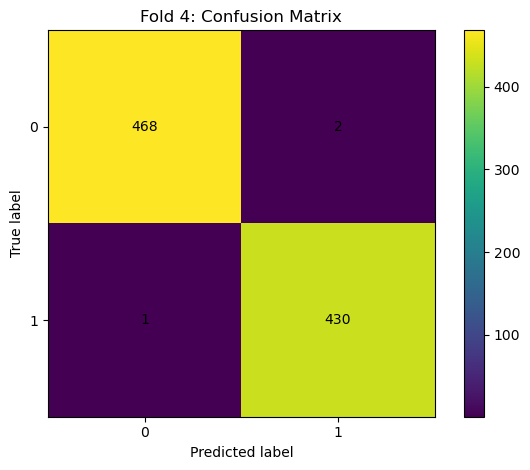

[PLOT] Fold 4: Accuracy / Loss curves


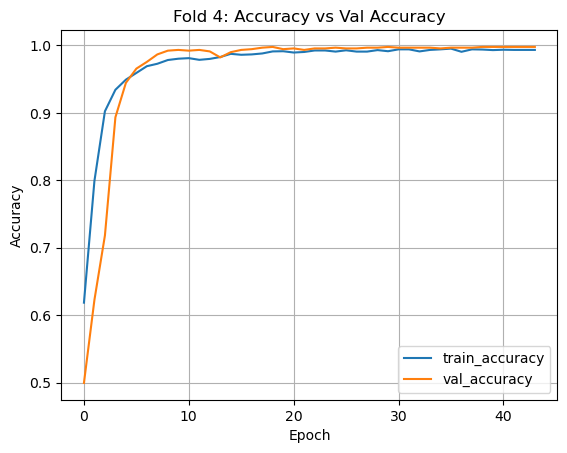

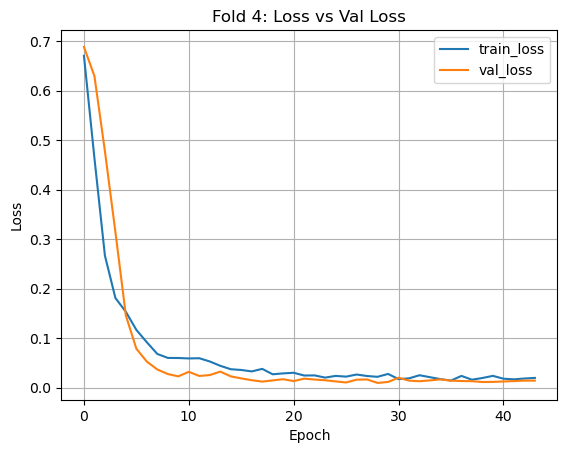


[CV] Fold 5/5
[CV] Fold 5 shapes -> Train: (3604, 14, 200, 1), Val: (901, 14, 200, 1)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer_4 (InputLayer)                          │ (None, 14, 200, 1)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv2d_4 (Conv2D)                                   │ (None, 14, 200, 16)                    │                 1,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_12 (BatchNormalization)         │ (None, 14, 200, 16)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ depthwise_conv2d_4 (DepthwiseConv2D)                │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_13 (BatchNormalization)         │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ activation_8 (Activation)                           │ (None, 1, 200, 32)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ average_pooling2d_8 (AveragePooling2D)              │ (None, 1, 50, 32)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout_8 (Dropout)                                 │ (None, 1, 50, 32)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ separable_conv2d_4 (SeparableConv2D)                │ (None, 1, 50, 16)                      │                 1,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_14 (BatchNormalization)         │ (None, 1, 50, 16)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ activation_9 (Activation)                           │ (None, 1, 50, 16)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ average_pooling2d_9 (AveragePooling2D)              │ (None, 1, 6, 16)                       │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout_9 (Dropout)                                 │ (None, 1, 6, 16)                       │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ flatten_4 (Flatten)                                 │ (None, 96)                             │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_8 (Dense)                                     │ (None, 64)                             │                 6,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_9 (Dense)                                     │ (None, 1)                              │                   
└─────────────────────────────────────────────────────┴─

 Total params: 9,025 (35.25 KB)

 Trainable params: 8,897 (34.75 KB)

 Non-trainable params: 128 (512.00 B)

None
[CALLBACKS] Setting up EarlyStopping & ReduceLROnPlateau...
[CV] Training fold 5...
Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6482 - loss: 0.6337 - val_accuracy: 0.6981 - val_loss: 0.6646 - learning_rate: 0.0010
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8069 - loss: 0.4367 - val_accuracy: 0.6626 - val_loss: 0.6093 - learning_rate: 0.0010
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9007 - loss: 0.2596 - val_accuracy: 0.8069 - val_loss: 0.4318 - learning_rate: 0.0010
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9456 - loss: 0.1625 - val_accuracy: 0.9445 - val_loss: 0.2122 - learning_rate: 0.0010
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9614 - loss: 0.1168 - val_accuracy: 0.9689 - val_loss: 0.1408 - learning_rate: 0.0010
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9673 - loss: 0.0988 - val_accuracy: 0.9889 - val_loss: 0.0495 - learning_rate: 0.0010

[CV] Fold 5 training complete.
[SAVE] Saved fold-5 model -> jack-fold5.h5
[CV][Fold 5] last-epoch -> train_acc: 0.9958, val_acc: 0.9956, train_loss: 0.0154, val_loss: 0.0150
[CV][Fold 5] best -> epoch: 21, best_val_loss: 0.0088, best_val_acc: 0.9967
[CM][Fold 5] Confusion Matrix (rows=true [0,1], cols=pred [0,1]):
[[496   3]
 [  0 402]]
[CM][Fold 5] TN=496, FP=3, FN=0, TP=402
[CM][Fold 5] accuracy=0.9967, precision=0.9926, recall=1.0000, f1=0.9963


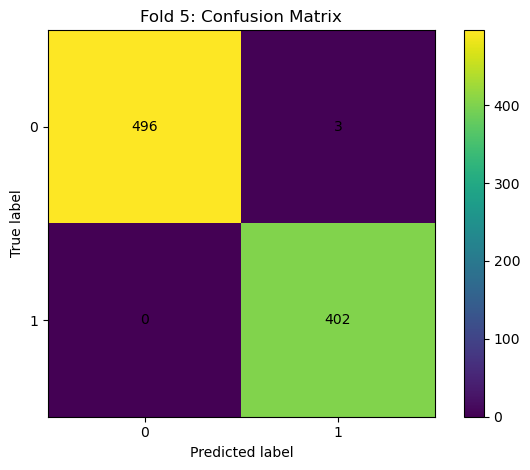

[PLOT] Fold 5: Accuracy / Loss curves


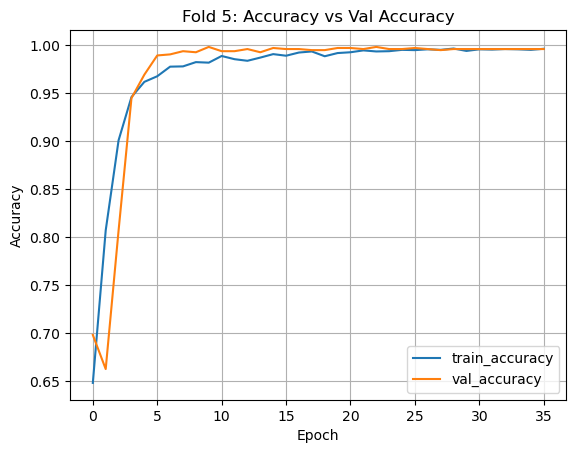

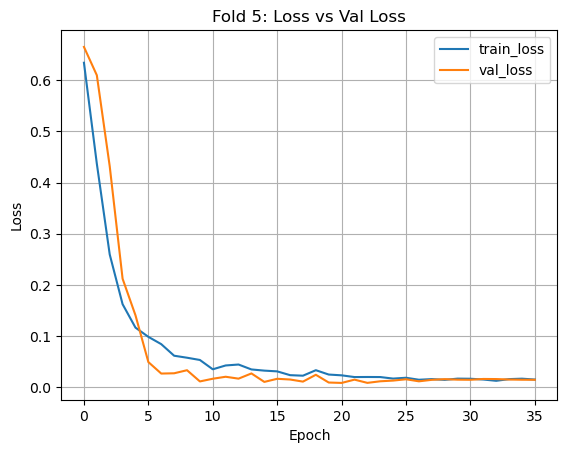


[SUMMARY] 5-Fold CV results (last epoch & best validation):
  - Fold 1: last(train_acc=0.9972, val_acc=0.9933, train_loss=0.0112, val_loss=0.0165) | best(epoch=24, val_loss=0.0126, val_acc=0.9967)
  - Fold 2: last(train_acc=0.9936, val_acc=0.9967, train_loss=0.0191, val_loss=0.0112) | best(epoch=29, val_loss=0.0083, val_acc=0.9967)
  - Fold 3: last(train_acc=0.9978, val_acc=1.0000, train_loss=0.0072, val_loss=0.0004) | best(epoch=60, val_loss=0.0004, val_acc=1.0000)
  - Fold 4: last(train_acc=0.9933, val_acc=0.9978, train_loss=0.0196, val_loss=0.0141) | best(epoch=29, val_loss=0.0094, val_acc=0.9967)
  - Fold 5: last(train_acc=0.9958, val_acc=0.9956, train_loss=0.0154, val_loss=0.0150) | best(epoch=21, val_loss=0.0088, val_acc=0.9967)

[SUMMARY] Confusion Matrices & Metrics per Fold:
  - Fold 1: CM[TN=483, FP=1, FN=2, TP=415] | accuracy=0.9967, precision=0.9976, recall=0.9952, f1=0.9964
  - Fold 2: CM[TN=470, FP=1, FN=2, TP=428] | accuracy=0.9967, precision=0.9977, recall=0.9953, f1=0

In [9]:
# ====================================================================
# Cell 4: 5-fold CV (EEGNet), callbacks, plots, save fold models,
#         + confusion matrix & metrics per fold (with CM PLOT)
# ====================================================================

import tensorflow as tf  # TensorFlow for deep learning
from tensorflow.keras import backend as K  # Keras backend utilities
from tensorflow.keras.layers import (  # Keras layers we'll use
    Input, SeparableConv2D, BatchNormalization, Activation,
    DepthwiseConv2D, Conv2D, Add, AveragePooling2D,
    Dropout, Reshape, GlobalAveragePooling1D, Dense,
    GlobalAveragePooling2D, LayerNormalization, MultiHeadAttention, Flatten
)
from tensorflow.keras.models import Model  # For building the model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Training callbacks
from tensorflow.keras.optimizers import Adam  # Optimizer
from tensorflow.keras.losses import BinaryCrossentropy  # Binary classification loss
from tensorflow.keras.metrics import BinaryAccuracy  # Metric as requested
from sklearn.model_selection import KFold  # K-fold CV splitter
from sklearn.metrics import confusion_matrix  # For confusion matrix
import matplotlib.pyplot as plt  # Plotting
import numpy as np  # Numerical ops
import os  # Filesystem ops

# --------------------------------------------------------------------
# Reproducibility
# --------------------------------------------------------------------
tf.random.set_seed(44)  # Fix TF RNG seed
np.random.seed(44)      # Fix NumPy RNG seed

# --------------------------------------------------------------------
# EEGNet (replacing AFNet) — architecture only; we compile below to keep the rest identical
# --------------------------------------------------------------------
def create_eegnet_model(input_shape, dropout_rate=0.5, num_classes=1):
    """
    EEGNet-style CNN for EEG:
      - temporal Conv2D
      - depthwise spatial filtering across electrodes
      - separable conv block
      - dense head
    """
    inputs = Input(shape=input_shape)

    # First Conv2D layer (temporal filtering)
    x = Conv2D(16, (1, 64), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)

    # Depthwise spatial conv across electrodes
    x = DepthwiseConv2D((input_shape[0], 1), depth_multiplier=2, padding='valid', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropout_rate)(x)

    # SeparableConv2D layer (spatial/temporal refinement)
    x = SeparableConv2D(16, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 8))(x)
    x = Dropout(dropout_rate)(x)

    # Dense head
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# --------------------------------------------------------------------
# Compile model (unchanged API)
# --------------------------------------------------------------------
def compile_model():  # Build+compile
    # Infer input shape from your training tensor to keep everything else unchanged
    # Expected Xtr shape: (N, electrodes, timesteps, 1)
    input_shape = (int(Xtr.shape[1]), int(Xtr.shape[2]), int(Xtr.shape[3]))
    model = create_eegnet_model(input_shape=input_shape, dropout_rate=0.5, num_classes=1)
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(name='accuracy', threshold=0.5)]
    )
    print(model.summary(line_length=120))
    return model

def make_callbacks():  # Create callbacks
    print("[CALLBACKS] Setting up EarlyStopping & ReduceLROnPlateau...")  # Log
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)  # Early stop
    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)  # LR schedule
    return [es, rlrop]  # Return callbacks

# --------------------------------------------------------------------
# Training data from Step 3 (expects train_data_norm / y_train in scope)
# --------------------------------------------------------------------
Xtr = train_data_norm  # Inputs
ytr = y_train.astype(np.float32)  # Labels
print(f"[TRAIN] Using TRAIN set for CV -> Xtr: {Xtr.shape}, ytr: {ytr.shape}")  # Log
print("[INFO] daniel (TEST) will be used only after CV for final evaluation (Steps 5–6).")  # Note

# --------------------------------------------------------------------
# 5-fold Cross-Validation (unchanged)
# --------------------------------------------------------------------
n_splits = 5  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)  # CV splitter

fold_histories = []  # Store histories
fold_summaries = []  # Store last/best stats
fold_confusions = []  # Store confusion matrices
fold_metrics_from_cm = []  # Store metrics derived from CM

print(f"[CV] Starting {n_splits}-fold cross-validation...")  # Log
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(Xtr, ytr), start=1):  # Loop folds
    print("\n" + "="*80)
    print(f"[CV] Fold {fold_idx}/{n_splits}")
    print("="*80)

    X_train_fold = Xtr[train_idx]
    y_train_fold = ytr[train_idx]
    X_val_fold   = Xtr[val_idx]
    y_val_fold   = ytr[val_idx]

    print(f"[CV] Fold {fold_idx} shapes -> Train: {X_train_fold.shape}, Val: {X_val_fold.shape}")

    model = compile_model()  # EEGNet model now
    callbacks = make_callbacks()

    print(f"[CV] Training fold {fold_idx}...")
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=200,
        batch_size=64,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks,
        verbose=1
    )
    print(f"[CV] Fold {fold_idx} training complete.")

    fold_model_path = f"jack-fold{fold_idx}.h5"
    model.save(fold_model_path)
    print(f"[SAVE] Saved fold-{fold_idx} model -> {fold_model_path}")

    hist = history.history
    fold_histories.append(hist)

    train_acc_last = hist.get('accuracy',    [None])[-1]
    val_acc_last   = hist.get('val_accuracy',[None])[-1]
    train_loss_last= hist.get('loss',        [None])[-1]
    val_loss_last  = hist.get('val_loss',    [None])[-1]

    best_epoch = int(np.argmin(hist.get('val_loss', [np.inf]))) + 1
    best_val_loss = float(np.min(hist['val_loss']))
    best_val_acc  = float(hist['val_accuracy'][best_epoch-1])

    fold_summaries.append({
        "fold": fold_idx,
        "last_train_acc": float(train_acc_last) if train_acc_last is not None else None,
        "last_val_acc":   float(val_acc_last)   if val_acc_last   is not None else None,
        "last_train_loss":float(train_loss_last)if train_loss_last is not None else None,
        "last_val_loss":  float(val_loss_last)  if val_loss_last  is not None else None,
        "best_epoch":     best_epoch,
        "best_val_loss":  best_val_loss,
        "best_val_acc":   best_val_acc
    })

    print(f"[CV][Fold {fold_idx}] last-epoch -> "
          f"train_acc: {train_acc_last:.4f}, val_acc: {val_acc_last:.4f}, "
          f"train_loss: {train_loss_last:.4f}, val_loss: {val_loss_last:.4f}")
    print(f"[CV][Fold {fold_idx}] best -> epoch: {best_epoch}, "
          f"best_val_loss: {best_val_loss:.4f}, best_val_acc: {best_val_acc:.4f}")

    # ------------------------------------------------------------
    # Confusion matrix & metrics FROM the CM (per fold) + PLOT
    # ------------------------------------------------------------
    y_val_prob = model.predict(X_val_fold, verbose=0).ravel()
    y_val_pred = (y_val_prob >= 0.5).astype(int)
    y_val_true = y_val_fold.astype(int)

    cm = confusion_matrix(y_val_true, y_val_pred, labels=[0, 1])
    fold_confusions.append(cm)

    tn, fp, fn, tp = cm.ravel()
    eps = 1e-12
    accuracy_cm  = (tp + tn) / max(tp + tn + fp + fn, eps)
    precision_cm = tp / max(tp + fp, eps)
    recall_cm    = tp / max(tp + fn, eps)
    f1_cm        = 2 * precision_cm * recall_cm / max(precision_cm + recall_cm, eps)

    fold_metrics_from_cm.append({
        "fold": fold_idx, "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp),
        "accuracy": float(accuracy_cm), "precision": float(precision_cm),
        "recall": float(recall_cm), "f1": float(f1_cm)
    })

    print(f"[CM][Fold {fold_idx}] Confusion Matrix (rows=true [0,1], cols=pred [0,1]):")
    print(cm)
    print(f"[CM][Fold {fold_idx}] TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print(f"[CM][Fold {fold_idx}] accuracy={accuracy_cm:.4f}, precision={precision_cm:.4f}, "
          f"recall={recall_cm:.4f}, f1={f1_cm:.4f}")

    # ---------- CM plot ----------
    plt.figure()
    plt.imshow(cm, interpolation='nearest')  # no explicit colormap
    plt.title(f'Fold {fold_idx}: Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # ---------- Accuracy/Loss curves (unchanged) ----------
    print(f"[PLOT] Fold {fold_idx}: Accuracy / Loss curves")
    plt.figure()
    plt.plot(hist.get('accuracy', []), label='train_accuracy')
    plt.plot(hist.get('val_accuracy', []), label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Fold {fold_idx}: Accuracy vs Val Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist.get('loss', []), label='train_loss')
    plt.plot(hist.get('val_loss', []), label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold_idx}: Loss vs Val Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# --------------------------------------------------------------------
# Summary printouts (unchanged + CM metrics table)
# --------------------------------------------------------------------
print("\n[SUMMARY] 5-Fold CV results (last epoch & best validation):")
for s in fold_summaries:
    print(f"  - Fold {s['fold']}: "
          f"last(train_acc={s['last_train_acc']:.4f}, val_acc={s['last_val_acc']:.4f}, "
          f"train_loss={s['last_train_loss']:.4f}, val_loss={s['last_val_loss']:.4f}) | "
          f"best(epoch={s['best_epoch']}, val_loss={s['best_val_loss']:.4f}, val_acc={s['best_val_acc']:.4f})")

print("\n[SUMMARY] Confusion Matrices & Metrics per Fold:")
for m in fold_metrics_from_cm:
    print(f"  - Fold {m['fold']}: CM[TN={m['TN']}, FP={m['FP']}, FN={m['FN']}, TP={m['TP']}] | "
          f"accuracy={m['accuracy']:.4f}, precision={m['precision']:.4f}, "
          f"recall={m['recall']:.4f}, f1={m['f1']:.4f}")

print("\n[INFO] Cross-validation complete. Saved models: jack-fold1.h5 ... jack-fold5.h5")


Step 5: Inference

In [10]:
# ============================================================
# Cell 5: Inference on TEST (adam) with all 5 saved fold models
#        (robust loader; supports current dir or models_cv/)
# ============================================================

import os
import numpy as np
from tensorflow.keras.models import load_model

# --- 1) Prepare TEST data from Step 3 (safe fallback) ---
print("[TEST] Preparing TEST (daniel) arrays from Step 3 artifacts...")

# If Xte/yte not defined yet, pull from Step 3 variables
if 'Xte' not in globals() or 'yte' not in globals():
    # Expect these to exist from Step 3
    Xte = test_data_norm                     # (M, 14, 200, 1)
    yte = y_test.astype(np.int32)            # (M,)

print(f"[TEST] Xte shape: {Xte.shape}, yte shape: {yte.shape}")

# --- 2) Locate saved fold models ---
# Step 4 (latest) saved in current directory as adam-fold1.h5 ... adam-fold5.h5
paths_current = [f"jack-fold{i}.h5" for i in range(1, 6)]
paths_models_cv = [os.path.join("models_cv", f"jack-fold{i}.h5") for i in range(1, 6)]

# Prefer current-dir models; if missing, fall back to models_cv/
use_models = []
for p_cur, p_cv in zip(paths_current, paths_models_cv):
    if os.path.exists(p_cur):
        use_models.append(p_cur)
    elif os.path.exists(p_cv):
        use_models.append(p_cv)
    else:
        use_models.append(None)

# Verify we have at least 3 models (so ensemble can still run)
available = [p for p in use_models if p is not None]
if len(available) == 0:
    raise FileNotFoundError(
        "No fold models found. Expected 'cole-fold#.h5' in current directory or in 'models_cv/'. "
        "Please re-run Step 4 to generate the models."
    )

print("[TEST] Model files to be used:")
for i, p in enumerate(use_models, start=1):
    print(f"  Fold {i}: {p if p is not None else '[MISSING]'}")

# --- 3) Predict with each available model ---
# Because Step 4 uses a custom layer (ElectrodeRepeat), we pass it via custom_objects.
# It was defined in Step 4 and is registered, but providing it explicitly is robust.

# If ElectrodeRepeat is not in globals (e.g., kernel restart), define a no-op reference to avoid NameError.
if 'ElectrodeRepeat' not in globals():
    try:
        from tensorflow.keras.utils import get_custom_objects  # not strictly needed
    except Exception:
        pass
    # The model will still load because it was @register_keras_serializable in Step 4.
    # This placeholder only prevents NameError in 'custom_objects' dict below.
    class ElectrodeRepeat(tf.keras.layers.Layer):
        pass

all_fold_probs = []   # list of (M,) predicted probabilities per fold
all_fold_preds = []   # list of (M,) predicted labels per fold
loaded_folds = []     # which folds actually loaded/predicted

print("[TEST] Loading models and running predictions...")
for i, mpath in enumerate(use_models, start=1):
    if mpath is None:
        print(f"[WARN] Fold {i}: model file not found; skipping this fold.")
        continue

    try:
        print(f"[TEST] Loading model for Fold {i}: {mpath}")
        model = load_model(mpath, custom_objects={"ElectrodeRepeat": ElectrodeRepeat}, compile=False)

        print(f"[TEST] Predicting with Fold {i} on {Xte.shape[0]} samples...")
        y_prob = model.predict(Xte, verbose=0).ravel()       # (M,) probabilities
        y_pred = (y_prob >= 0.5).astype(np.int32)            # (M,) hard labels

        all_fold_probs.append(y_prob)
        all_fold_preds.append(y_pred)
        loaded_folds.append(i)

        print(f"[TEST] Fold {i}: predictions={y_pred.shape[0]}, positive-rate={y_pred.mean():.4f}")
    except Exception as e:
        print(f"[ERROR] Failed to load/predict with Fold {i} model '{mpath}'. Error: {e}")
        print("[HINT] If this persists, re-run Step 4 to regenerate models with ElectrodeRepeat defined.")

# Final check
if len(all_fold_preds) == 0:
    raise RuntimeError("No predictions were produced. Ensure at least one fold model loads successfully.")

print(f"[TEST] Per-fold predictions complete. Successful folds: {loaded_folds}")


[TEST] Preparing TEST (daniel) arrays from Step 3 artifacts...
[TEST] Xte shape: (265, 14, 200, 1), yte shape: (265,)
[TEST] Model files to be used:
  Fold 1: jack-fold1.h5
  Fold 2: jack-fold2.h5
  Fold 3: jack-fold3.h5
  Fold 4: jack-fold4.h5
  Fold 5: jack-fold5.h5
[TEST] Loading models and running predictions...
[TEST] Loading model for Fold 1: jack-fold1.h5
[TEST] Predicting with Fold 1 on 265 samples...
[TEST] Fold 1: predictions=265, positive-rate=0.6415
[TEST] Loading model for Fold 2: jack-fold2.h5
[TEST] Predicting with Fold 2 on 265 samples...
[TEST] Fold 2: predictions=265, positive-rate=0.7170
[TEST] Loading model for Fold 3: jack-fold3.h5
[TEST] Predicting with Fold 3 on 265 samples...
[TEST] Fold 3: predictions=265, positive-rate=0.6868
[TEST] Loading model for Fold 4: jack-fold4.h5
[TEST] Predicting with Fold 4 on 265 samples...
[TEST] Fold 4: predictions=265, positive-rate=0.5585
[TEST] Loading model for Fold 5: jack-fold5.h5
[TEST] Predicting with Fold 5 on 265 sample

Step 6 - Performance Matrices for each Fold

[CHECK] Verifying predictions and labels are available...
[CHECK] Found predictions for folds: [1, 2, 3, 4, 5]
[METRICS] Computing per-fold confusion matrices & metrics...

[Fold 1] Confusion Matrix:
[[  0   0]
 [ 95 170]]
[Fold 1] Accuracy : 0.6415
[Fold 1] Precision: 1.0000
[Fold 1] Recall   : 0.6415
[Fold 1] F1-score : 0.7816


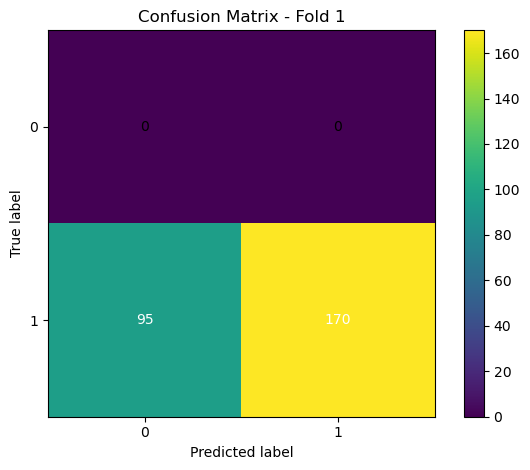


[Fold 2] Confusion Matrix:
[[  0   0]
 [ 75 190]]
[Fold 2] Accuracy : 0.7170
[Fold 2] Precision: 1.0000
[Fold 2] Recall   : 0.7170
[Fold 2] F1-score : 0.8352


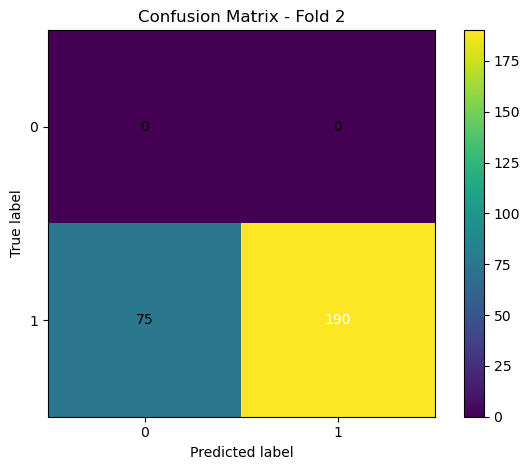


[Fold 3] Confusion Matrix:
[[  0   0]
 [ 83 182]]
[Fold 3] Accuracy : 0.6868
[Fold 3] Precision: 1.0000
[Fold 3] Recall   : 0.6868
[Fold 3] F1-score : 0.8143


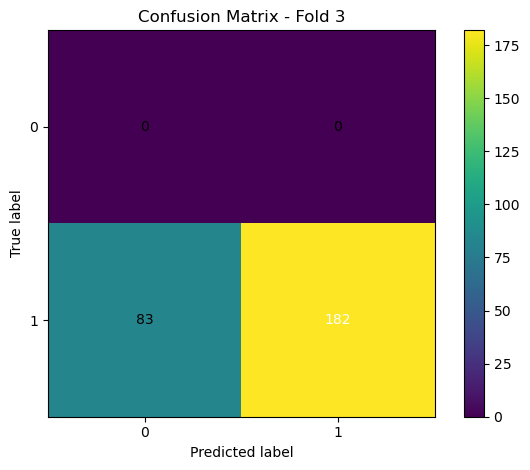


[Fold 4] Confusion Matrix:
[[  0   0]
 [117 148]]
[Fold 4] Accuracy : 0.5585
[Fold 4] Precision: 1.0000
[Fold 4] Recall   : 0.5585
[Fold 4] F1-score : 0.7167


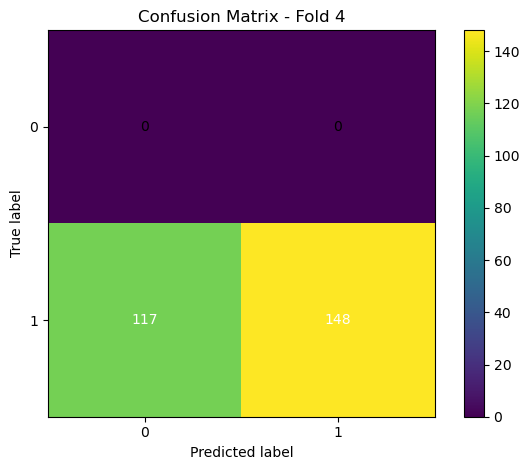


[Fold 5] Confusion Matrix:
[[  0   0]
 [ 66 199]]
[Fold 5] Accuracy : 0.7509
[Fold 5] Precision: 1.0000
[Fold 5] Recall   : 0.7509
[Fold 5] F1-score : 0.8578


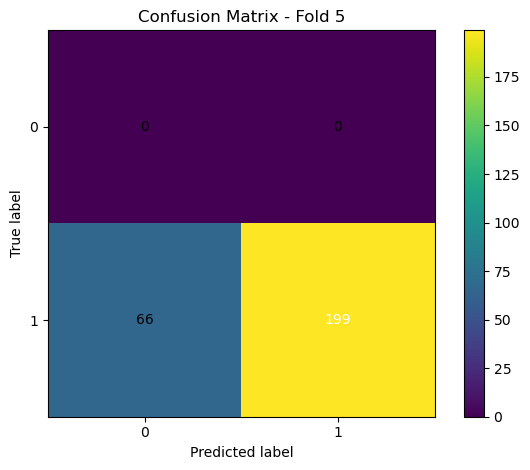


[ENSEMBLE] Performing majority vote ensembling...
[ENSEMBLE] Using 5 model(s). pred_matrix shape: (5, 265)
[ENSEMBLE] Applying your rule: class 0 if at least 3/5 predict 0; else class 1.
[ENSEMBLE] Example: first 10 avg probs: [0.99937373 0.99107295 0.9997136  0.09757479 0.04015657 0.20743532
 0.9800267  0.88694584 0.35285228 0.07539535]

[ENSEMBLE] Confusion Matrix:
 [[  0   0]
 [ 87 178]]
[ENSEMBLE] Accuracy : 0.6717
[ENSEMBLE] Precision: 1.0000
[ENSEMBLE] Recall   : 0.6717
[ENSEMBLE] F1-score : 0.8036


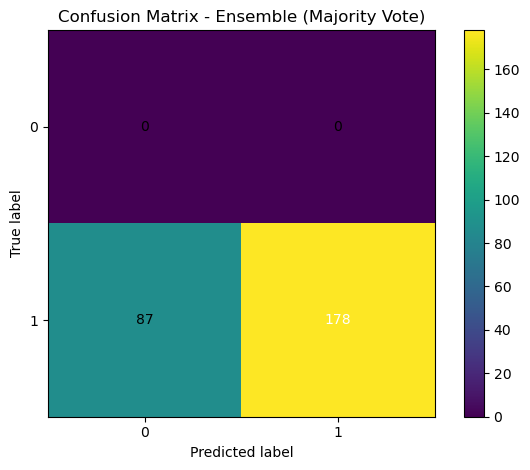

[DONE] Per-fold and ensemble evaluation complete.


In [11]:
# =======================================================================================
# Cell 6: Per-fold confusion matrices & metrics + Ensemble (majority vote) on adam (TEST)
# =======================================================================================

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def compute_metrics_from_cm(cm):
    """
    Given a 2x2 confusion matrix [[tn, fp],[fn, tp]],
    compute accuracy, precision, recall, f1 with numerical stability.
    """
    tn, fp, fn, tp = cm.ravel()
    eps = 1e-12
    accuracy  = (tp + tn) / (tp + tn + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1_score  = 2 * precision * recall / (precision + recall + eps)
    return accuracy, precision, recall, f1_score

def plot_confusion_matrix(cm, title):
    """
    Simple confusion matrix plot with counts.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0','1'])
    plt.yticks(tick_marks, ['0','1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# ---------------------------
# Validate upstream artifacts
# ---------------------------
print("[CHECK] Verifying predictions and labels are available...")
if 'all_fold_preds' not in globals() or len(all_fold_preds) == 0:
    raise RuntimeError("No per-fold predictions found. Please run Step 5 first.")

if 'yte' not in globals():
    raise RuntimeError("Test labels 'yte' not found. Ensure Step 3 & Step 5 have run.")

M = len(yte)
for i, arr in enumerate(all_fold_preds, start=1):
    if arr.shape[0] != M:
        raise ValueError(f"Fold {i} predictions have shape {arr.shape}, expected ({M},).")

# If Step 5 recorded which folds loaded, use it for better logging
fold_ids = globals().get('loaded_folds', list(range(1, len(all_fold_preds) + 1)))
print(f"[CHECK] Found predictions for folds: {fold_ids}")

# ---------------------------
# Per-fold metrics
# ---------------------------
print("[METRICS] Computing per-fold confusion matrices & metrics...")
for i, y_pred in enumerate(all_fold_preds, start=1):
    cm = confusion_matrix(yte, y_pred, labels=[0, 1])
    acc, prec, rec, f1 = compute_metrics_from_cm(cm)
    fold_label = fold_ids[i-1] if i-1 < len(fold_ids) else i
    print(f"\n[Fold {fold_label}] Confusion Matrix:\n{cm}")
    print(f"[Fold {fold_label}] Accuracy : {acc:.4f}")
    print(f"[Fold {fold_label}] Precision: {prec:.4f}")
    print(f"[Fold {fold_label}] Recall   : {rec:.4f}")
    print(f"[Fold {fold_label}] F1-score : {f1:.4f}")
    
    # Optional: plot for each fold
    plot_confusion_matrix(cm, title=f'Confusion Matrix - Fold {fold_label}')

# ---------------------------
# Ensemble (majority vote)
# Rule (original): If 3 out of 5 predict 0 -> class 0, else class 1
# If fewer/more than 5 models available, use majority threshold = floor(n/2)+1
# ---------------------------
print("\n[ENSEMBLE] Performing majority vote ensembling...")

n_models = len(all_fold_preds)
pred_matrix = np.vstack(all_fold_preds)   # shape: (n_models, M)
print(f"[ENSEMBLE] Using {n_models} model(s). pred_matrix shape: {pred_matrix.shape}")

if n_models == 5:
    threshold_zero = 3   # your exact rule
    print("[ENSEMBLE] Applying your rule: class 0 if at least 3/5 predict 0; else class 1.")
else:
    threshold_zero = (n_models // 2) + 1  # strict majority for general case
    print(f"[ENSEMBLE] Non-5 model count detected. Using majority threshold: {threshold_zero}/{n_models} zeros -> class 0.")

# Count zeros across folds; decide 0 if zeros >= threshold_zero, else 1
zeros_count = np.sum(pred_matrix == 0, axis=0)                  # (M,)
y_pred_ensemble = np.where(zeros_count >= threshold_zero, 0, 1).astype(np.int32)

# Also compute average probability (optional) if available
if 'all_fold_probs' in globals() and len(all_fold_probs) == n_models:
    avg_probs = np.mean(np.vstack(all_fold_probs), axis=0)      # (M,)
    print(f"[ENSEMBLE] Example: first 10 avg probs: {avg_probs[:10]}")
else:
    print("[ENSEMBLE] Probabilities not available for all folds; skipping avg prob print.")

# Metrics for ensemble
cm_ens = confusion_matrix(yte, y_pred_ensemble, labels=[0, 1])
acc_e, prec_e, rec_e, f1_e = compute_metrics_from_cm(cm_ens)

print("\n[ENSEMBLE] Confusion Matrix:\n", cm_ens)
print(f"[ENSEMBLE] Accuracy : {acc_e:.4f}")
print(f"[ENSEMBLE] Precision: {prec_e:.4f}")
print(f"[ENSEMBLE] Recall   : {rec_e:.4f}")
print(f"[ENSEMBLE] F1-score : {f1_e:.4f}")

# Plot ensemble confusion matrix
plot_confusion_matrix(cm_ens, title='Confusion Matrix - Ensemble (Majority Vote)')

print("[DONE] Per-fold and ensemble evaluation complete.")


In [12]:
# ======================================================================
# Step 7 / Cell 7: Per-model prediction arrays + 6-column comparison DF
#                  (5 model columns + majority vote) and save to CSV
# ======================================================================

import numpy as np
import pandas as pd
import os

print("[STEP 7] Building per-sample comparison table for 5 models + majority vote...")

# ---------------------------
# Sanity checks
# ---------------------------
if 'all_fold_preds' not in globals() or len(all_fold_preds) == 0:
    raise RuntimeError("[STEP 7] No per-fold predictions found. Please run Step 5 first.")

if 'yte' not in globals():
    raise RuntimeError("[STEP 7] Test labels 'yte' not found. Ensure Step 3 & Step 5 have run.")

M = len(yte)
for i, arr in enumerate(all_fold_preds, start=1):
    if arr.shape[0] != M:
        raise ValueError(f"[STEP 7] Fold {i} predictions have shape {arr.shape}, expected ({M},).")

# Confirm/print which folds these arrays correspond to (from Step 5), or fall back to 1..n
fold_ids = globals().get('loaded_folds', list(range(1, len(all_fold_preds) + 1)))
n_models = len(all_fold_preds)
print(f"[STEP 7] Found predictions for folds: {fold_ids} (n_models={n_models})")

# ---------------------------
# Controls for printing verbosity
# ---------------------------
PRINT_FULL   = False   # True = print the entire array for each model (can be long)
CHUNK_SIZE   = 50      # used if PRINT_FULL is False (chunked printing)
SHOW_HEAD    = 20      # quick look: first N values
SHOW_TAIL    = 20      # quick look: last  N values

# ---------------------------
# Utility: pretty chunk printer
# ---------------------------
def _print_chunks(arr, chunk_size=50):
    n = arr.shape[0]
    for start in range(0, n, chunk_size):
        end = min(start + chunk_size, n)
        print(f"  [{start:04d}:{end:04d}) -> {arr[start:end]}")

# ---------------------------
# 1) Print the five arrays (one per model) with basic stats
# ---------------------------
for idx, (fold, preds) in enumerate(zip(fold_ids, all_fold_preds), start=1):
    print("\n" + "="*80)
    print(f"[STEP 7][MODEL {idx} / FOLD {fold}] Prediction array (len={preds.shape[0]})")
    print("="*80)
    zeros = int(np.sum(preds == 0))
    ones  = int(np.sum(preds == 1))
    print(f"[STATS] zeros: {zeros}, ones: {ones}")
    print(f"[HEAD {SHOW_HEAD}] {preds[:SHOW_HEAD]}")
    print(f"[TAIL {SHOW_TAIL}] {preds[-SHOW_TAIL:]}")

    if PRINT_FULL:
        print("[FULL ARRAY]")
        print(preds)
    else:
        print(f"[CHUNKED] Printing in chunks of {CHUNK_SIZE}:")
        _print_chunks(preds, CHUNK_SIZE)

# ---------------------------
# 2) Build the (M x 5) prediction matrix
#    (If fewer than 5 models loaded, pad columns with NaN to keep 6-column DF shape)
# ---------------------------
print("\n[STEP 7] Stacking predictions into matrix...")
pred_matrix = np.vstack(all_fold_preds)         # shape: (n_models, M)

if n_models < 5:
    print(f"[WARN] Only {n_models} model(s) available; padding to 5 columns with NaN.")
    pad_cols = 5 - n_models
    pad_block = np.full((pad_cols, M), np.nan, dtype=float)
    pred_matrix_5 = np.vstack([pred_matrix, pad_block])  # (5, M)
else:
    pred_matrix_5 = pred_matrix[:5, :]                   # (5, M) – enforce exactly 5

# transpose to (M, 5) for DataFrame
pred_cols = pred_matrix_5.T
print(f"[STEP 7] pred_matrix shape: {pred_matrix.shape} -> pred_cols (for DF): {pred_cols.shape}")

# ---------------------------
# 3) Majority vote (your rule): 0 if >= 3 of 5 predict 0, else 1
#    If fewer than 5 models, use strict majority = floor(n/2)+1
# ---------------------------
if n_models == 5:
    threshold_zero = 3
    print("[STEP 7] Applying your exact rule: class 0 if at least 3/5 predict 0; otherwise class 1.")
    zeros_count = np.sum(pred_matrix == 0, axis=0)      # (M,)
    majority_vote = np.where(zeros_count >= threshold_zero, 0, 1).astype(np.int32)
else:
    threshold_zero = (n_models // 2) + 1
    print(f"[STEP 7] Non-5 model count: {n_models}. Using strict majority threshold: {threshold_zero}/{n_models}.")
    zeros_count = np.sum(pred_matrix == 0, axis=0)
    # For samples with NaN padding (when n_models<5), zeros_count unaffected. We still vote over available models.
    majority_vote = np.where(zeros_count >= threshold_zero, 0, 1).astype(np.int32)

print(f"[STEP 7] Majority vote example (first 20): {majority_vote[:20]}")

# ---------------------------
# 4) Build the DataFrame: 5 model columns + majority_vote (6th)
# ---------------------------
col_names = [f"model_{i}" for i in range(1, 6)]
df_compare = pd.DataFrame(pred_cols, columns=col_names)
df_compare["majority_vote"] = majority_vote

# Optional: human-readable label
label_map = {0: "amateur", 1: "professional"}
df_compare["majority_label"] = df_compare["majority_vote"].map(label_map)

print("\n[STEP 7] DataFrame preview (first 10 rows):")
print(df_compare.head(10))

print("\n[STEP 7] Class counts (majority_vote):")
print(df_compare["majority_vote"].value_counts(dropna=False))

# ---------------------------
# 5) Save to CSV
# ---------------------------
out_csv = "jack-majority-voting.csv"
df_compare.to_csv(out_csv, index=True)  # index = sample id
print(f"\n[SAVE] Wrote comparison table to: {out_csv}")
print("[STEP 7] Done.")


[STEP 7] Building per-sample comparison table for 5 models + majority vote...
[STEP 7] Found predictions for folds: [1, 2, 3, 4, 5] (n_models=5)

[STEP 7][MODEL 1 / FOLD 1] Prediction array (len=265)
[STATS] zeros: 95, ones: 170
[HEAD 20] [1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[TAIL 20] [1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
[CHUNKED] Printing in chunks of 50:
  [0000:0050) -> [1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0
 0 1 1 1 1 0 0 0 1 0 1 1 1]
  [0050:0100) -> [0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 0 0 0]
  [0100:0150) -> [0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1]
  [0150:0200) -> [1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 1]
  [0200:0250) -> [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0]
  [0250:0265) -> [0 0 0 0 0 0 0

[STEP 8A] Plotting distribution of 'majority_label'...
[STEP 8A] Counts:
 majority_label
amateur          87
professional    178
Name: count, dtype: int64


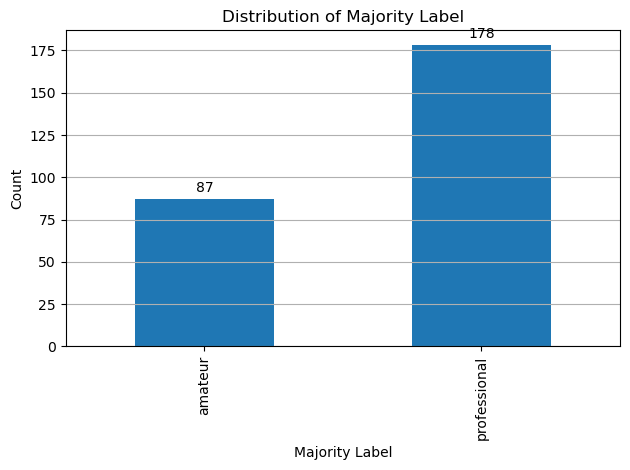

In [13]:
# ============================================================
# Step 8A: Bar chart of df_compare["majority_label"] distribution
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt

print("[STEP 8A] Plotting distribution of 'majority_label'...")

# Guards
if 'df_compare' not in globals():
    raise RuntimeError("[STEP 8A] 'df_compare' not found. Run Step 7 to build it.")

if "majority_label" not in df_compare.columns:
    raise RuntimeError("[STEP 8A] Column 'majority_label' not in df_compare. Run Step 7 to create it.")

# Order the classes explicitly (in case one class is missing)
order = ["amateur", "professional"]
counts = df_compare["majority_label"].value_counts().reindex(order, fill_value=0)

print("[STEP 8A] Counts:\n", counts)

# Plot
plt.figure()
ax = counts.plot(kind="bar")
ax.set_title("Distribution of Majority Label")
ax.set_xlabel("Majority Label")
ax.set_ylabel("Count")
ax.grid(True, axis="y")

# Annotate bars with counts
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{int(height)}", (p.get_x() + p.get_width()/2, height),
                ha="center", va="bottom", xytext=(0, 3), textcoords="offset points")

plt.tight_layout()
plt.show()
